# <ins>Agencement de qubits personnalisees pour une communication a plusieurs participants</ins>

****

_Contexte_: On veut pouvoir attribuer des qubits specifiques du processeur a des participants et les faire communiquer ensemble. Chaque participants peut faire son protocol avec ses qubits associes et peut les communiquer aux autres participants.

_Resume_: L'idee est de creer x participants avec leur propre registre et circuit quantique et les ajouter a un circuit global pour faire la communication entre participants. Tous les protocols se font sur les circuits individuels des participants. Par contre, les communications doivent se faire sur des circuits logiques temporaire et etre ajoute au circuit global. Chaque participant a aussi un dictionnaire d'arrangement de qubits pour agencer les qubits logiques du systeme global aux qubits physiques du processeur.

_Exemple_: Dans ce rapport, on montre l'utilisation de ce concept avec la communication entre 2 participants qui veulent trouver une intersection entre leur calendrier a l'aide de l'algorithme de Grover distribuee.
****

### **Import la librairie qiskit et quelques librairies de math.**

In [1]:
# uncomment on first run to install qiskit library
##############################################
#!pip install qiskit
#!pip install qiskit-ibm-runtime
##############################################

#initialization
import matplotlib.pyplot as plt  # plotting the results
import numpy as np               # create and manage arrays
# import math                      # using more complexe math operations

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.transpiler import CouplingMap

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex, plot_gate_map
from qiskit.circuit.library import MCMT, MCMTVChain, Diagonal

# import math tools
from math import floor, ceil, sqrt, pi, log2   # using more complexe math operations

### **Connexion a IBMQ et acces au processeur desire**

In [2]:
provider = IBMQ.load_account()

provider.backends()  # list of backends

backend = provider.get_backend("ibm_perth")
cm = CouplingMap(backend.configuration().coupling_map) # get the coupling map of the processor
plot_gate_map(backend)  # plot the layout of the processor

print(backend.configuration().basis_gates)

/tmp/ipykernel_35092/1176219718.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


['id', 'rz', 'sx', 'x', 'cx', 'reset']


### **Declaration des fonctions necessaires pour l'algorithme de Gover distribuee**

In [3]:
#######################################################################################################    
    
#      UTILITY
    
#######################################################################################################

# Initialize working qubits to |S> state
def Initialize_S(qc, first, last):
    """Apply a H-gate to 'qubits' in qc"""
    for q in range(last - first):
        qc.h(q + first)
    return qc

# return 2 dimensional array  that contains the bit number of each position:
# input = 4 -> output = [[0, 0], [0, 1], [1, 0], [1, 1]]
def CalculateBinary(number):
    array = []
    num_bits = ceil(log2(number))
    for num in range(number):
         array.append([(num >> bit) & 1 for bit in range(num_bits - 1, -1, -1)])
    return array

# return 2 dimensional array that write the qubit positions that contain a 0:
# input = [[0, 0], [0, 1], [1, 0], [1, 1]] -> output = [[0, 1], [0], [1], []]
def ExtractPosition(array):
    newArray2 = []
    for i in array:
        newArray1 = []
        q = 0
        for y in i:
            if y == 0:
                newArray1.append(q)
            q += 1
        newArray2.append(newArray1)
    return newArray2

# measure i qubits for i classical bit 
def MesureQubits(qc, nqubits):
    for i in range(nqubits):
        qc.measure(i, i)

# Ensure that two participants has their calendar of the same size        
def CheckCalendar(a, b):
    if len(a) != len(b):
        raise Exception("the two calendar must be the same size")

def InverseResults(results, threshold):

    best_results = []
    # result only consider elements over a certain threshold
    for r in results:
        if r[1] >= threshold:
            best_results.append(r[0])

    # inverse the binary result because qiskit have inversed result
    # Example: result = 001 = 1, true value = 100 = 4
    results = []
    for i in best_results:
        results.append(int(str(i)[::-1], 2))

    if not results:
        print("there are no solutions for these calendars")

    elif len(results) == 1:
        print("the solution is: ", results[0])
    else:
        print("there are", len(results),"solutions: ", results)

#######################################################################################################    
    
#      Create gates
    
#######################################################################################################

# apply the X gates in the circuit on the qubits that must be conditionned to zero for Alice  
def ApplyNOT(qc, pos): 
    if not pos:
        pass
    else:
        qc.x(pos)

#######################################################################################################    
    
#      Create Oracles
    
#######################################################################################################    

# Create the oracle circuit for Alice      
def CreateOracleAlice(qc, numPos, calendar, nqubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        bits = CalculateBinary(numPos)                            # possible positions in bit
        Xpos = ExtractPosition(bits)                              # indices of the qubits to apply X-gate
        targets = nqubits - 1                                     # number of targets in multi controlled gate
        MCMTPos = []
        for i in range(nqubits): 
            MCMTPos.append(i)                                     # append the position of the qubit to condition
#         print('MCMTPOS:', MCMTPos)
        i = 0
        for pos in Xpos:
            if calendar[i] == "1":
                ApplyNOT(qc, pos)                                # Apply not gates where contitioning 0
                qc.append(MCMT("x", targets, 1), MCMTPos)          # Apply multi-Toffoli gate
                ApplyNOT(qc, pos)                                # Apply not gates where contitioning 0
                qc.barrier()
            i += 1
    else:
        raise Exception("the calendar must be a power of 2")

# Create the oracle circuit for Bob
def CreateOracleBob(qc, numPos, calendar, nqubits): 
    if (ceil(log2(len(calendar))) == floor(log2(len(calendar)))): # calendar must be a power of 2
        bits = CalculateBinary(numPos)                            # possible positions in bit
        Xpos = ExtractPosition(bits)                              # indices of the qubits to apply X-gate
        targets = nqubits - 1                                     # number of targets in multi controlled gate
        MCMTPos = []
        for i in range(nqubits):
            MCMTPos.append(i)                           # append the position of the qubit to condition
        i = 0
        for pos in Xpos:
            if calendar[i] == "1":
                ApplyNOT(qc, pos)                          # Apply not gates where contitioning 0
                qc.append(MCMT("z", targets, 1), MCMTPos)         # Apply multi-controlled-z gate
                ApplyNOT(qc, pos)                          # Apply not gates where contitioning 0
                qc.barrier()
            i += 1 
    else:
        raise Exception("the calendar must be a power of 2")

        
# create a gate from the implementation of the diffuser 
def Diffuser(backend, nqubits):
    qc = QuantumCircuit(nqubits)
    # apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)                      # multi-controlled-toffoli
    qc.h(nqubits-1)
    # apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # return the diffuser as a gate
    tr_qc = transpile(qc, backend)
    return tr_qc

# add the diffuser to the circuit
def AddDiffuser(qc, backend, qr, nqubits):
    array = []
    for n in range(nqubits):
        array.append(qr * nqubits + n)
    qc.compose(Diffuser(backend, nqubits), inplace = True)

### **Declaration des fonctions necessaires pour l'arrangement des qubits selon le processeur**
___

L'agencement des qubits sert a definir quel qubit logique sera attribue a quel qubit physique. Il y a des agencement par defaut dependant du processeur, mais il est possible de donner un agencement personnalise avec l'attribut participant.layout[nqubits]. On peut aussi le definir a la creation du participant.

In [4]:
#######################################################################################################    
    
#      Utility
    
#######################################################################################################  


# constructor for the "Participant" class
class Participant:
    def __init__(self, pname, nqubits, q7_order = [], q16_order = [], q27_order = []):
        self.pname = pname                                                 # name
        self.nqubits = nqubits                                             # number of qubits in its register
        self.layout = {"7q": q7_order, "16q": q16_order, "27q": q27_order} # dictionnary for its layouts
        self.cm = None                                                     # coupling map
        self.map = []                                                      # array that stock the layout for the job
        self.qr = QuantumRegister(nqubits, name = pname)                   # quantum register of the participant
        self.qc = QuantumCircuit(nqubits)                                  # quantum circuit of the articipant
        self.qubits = []                                                   # qubits indices in the global circuit
        
    # function that allows to print the participant (why not)    
    def __str__(self):                            
        return f"{self.pname} ({self.nqubits}qubits)"   # print the name and the number of qubits of the participant  
    
# ensure that the number of qubits necessary does not exceed the number of qubits of the backend
def CheckQubitsError(backend, sumQubits):

    if backend.configuration().n_qubits >= sumQubits:
        print("Backend ok")
    else:
        print("backend qubits: ", backend.configuration().n_qubits, ", your total of qubits: ", sumQubits)
        raise Exception("your backend does not have enough qubits for your protocol")    
        
        
#######################################################################################################    
    
#      Layout functions
    
#######################################################################################################   

# Create an array (participant.map) that will be used as coupling map when transpiling
# inputs: array[Participant], nb qubits of the backend ("7q", "16q", etc)
def CreateParticipantMap(participants, nqubits_str):
    for p in participants:
        cm = []
        for i, j in zip(p.layout[nqubits_str], range(p.nqubits)):
            cm.extend([i])
        p.map = cm

# Create the coupling map of every participants based on the layout 
def CreateCouplingMaps(backend, participants):
    cm = CouplingMap(backend.configuration().coupling_map)
    if backend.configuration().n_qubits == 7:      
        for p in participants:
            p.cm = cm.reduce(p.map)
    elif backend.configuration().n_qubits == 16:  
        for p in participants:
            p.cm = cm.reduce(p.layout["16q"])
    else:
        raise Exception("No coupling map for this backend")

# create the layout for a processor of 7 qubits
def Create7qubitsLayout(backend, qc, participants):
    # participants cannot reserve more than 4 qubits each
    # for p in participants:
    #     if p.nqubits > 4:
    #         raise Exception("One or more participants cannot have more than 4 qubits")
    defaultLayout = True # bool: True if none of the participants has a 7q layout
    allFilled = True     # bool: false if all of the participants have a 7q layout
    
    for p in participants:
        if not p.layout["7q"]:
            defaultLayout = False
            break
    if defaultLayout == False:
        for p in participants:
            if not p.layout["7q"]:
                allFilled = False
                break
           
    # participants must both have a custom layout of none of them
    # if none of the participants has a custom layout, it will get the default one
    if defaultLayout: 

#################### default layout for 7 qubits ############################

            if len(participants) == 2:
                if participants[0].nqubits >= participants[1].nqubits:
                    participants[0].layout["7q"] =  [3]
                else:
                    participants[1].layout["7q"] = [3]
                    
                participants[0].layout["7q"].extend([ 1, 0, 2])
                participants[1].layout["7q"].extend([ 5, 4, 6])

            if len(participants) == 3:
                       
                participants[0].layout["7q"].extend([3])
                participants[1].layout["7q"].extend([1])
                participants[2].layout["7q"].extend([5])
        
############################################################################# 

    # all or none participants can have custom layout, not only some of them
    elif not defaultLayout and not allFilled:
        raise Exception("you must specify the layout for all participants")
           
#     print("p1 layout: ", participants[0].layout["7q"])
#     print("p2 layout: ", participants[1].layout["7q"]) 

    # create the coupling map to use for every participants
    CreateParticipantMap(participants, "7q") 


# create the layout for a processor of 16 qubits
def Create16qubitsLayout(backend, qc, participants):
    
    defaultLayout = True # bool: True if none of the participants has a 16q layout
    allFilled = True     # bool: false if all of the participants have a 16q layout
    
    for p in participants:
        if not p.layout["16q"]:
            defaultLayout = False
            break
    if defaultLayout == False:
        for p in participants:
            if not p.layout["16q"]:
                allFilled = False
                break
            
    print("defaultLayout = ", defaultLayout)
    
    qubitOrder = []
    if defaultLayout:
        # default layout for 2 participants
        if len(participants) == 2:
            # 8 qubits each
            qubitOrder.append = [ 1, 0, 4, 7, 6, 10, 12, 15]
            qubitOrder.append = [ 2, 3, 5, 8, 9, 11, 14, 13]
            
            for p, q in zip(participants, qubitOrder):
                p.layout["16q"].extend(q)

        # default layout for 3 participants
        elif len(participants) == 3:
            # 5 qubits each
            qubitOrder.append = [ 0, 1, 2, 3, 4]
            qubitOrder.append = [ 6, 7, 10, 12, 15]
            qubitOrder.append = [ 5, 8, 11, 14, 13]
            
            for p, q in zip(participants, qubitOrder):
                p.layout["16q"].extend([q])

                
        # default layout for 4 participants
        elif len(participants) == 4:
            # 4 qubits each
            qubitOrder.append = [ 0, 1, 2, 3]
            qubitOrder.append = [ 5, 8, 9, 11]
            qubitOrder.append = [ 14, 13, 12, 15]
            qubitOrder.append = [ 4, 7, 6, 10]
            
            for p, q in zip(participants, qubitOrder):
                p.layout["16q"].extend([q])

    # all or none participants can have custom layout, not only some of them
    elif not defaultLayout and not allFilled:
        raise Exception("you must specify the layout for all participants")

    # create the coupling map to use for every participants
    CreateParticipantMap(participants, "16q") 

# call the good layout function depending on the size of the backend
def CreateLayout(backend, qc, participants):
    sumQubits = 0

    for p in participants:
        sumQubits += p.nqubits

    CheckQubitsError(backend, sumQubits)     # raise exception if you need more qubits than the backend provides

    if backend == provider.get_backend("ibmq_jakarta") or provider.get_backend("ibm_perth") or provider.get_backend("ibm_lagos") or provider.get_backend("ibm_nairobi"):
        print("backend: ", backend, ", ", backend.configuration().n_qubits, "qubits")
        if len(participants) <= 3: # 7 qubits backend cannot have more than 3 participants
            Create7qubitsLayout(backend, qc, participants)
        else:
            raise Exception("Too much participants for this backend")
        
    elif backend == provider.get_backend("ibmq_guadalupe"):
        print("backend: ", backend, ", ", backend.configuration().n_qubits, "qubits")
        if len(participants) <= 4: # 16 qubits backend cannot have more than 4 participants
            Create16qubitsLayout(backend, qc, participants)
        else:
            raise Exception("Too much participants for this backend")
        
    else:
        raise Exception("No layout for this backend") # if no real backend correspond to the ackend provided


### Declaration des fonctions de communication inter-participants

___

Comme on veut avoir un assortiment de qubits specifique, on ne veut pas que le compilateur change notre configuration. On doit donc avoir un circuit global qui va etre compiler des le depart avec les registres des participants. C'est aussi important que chaque fois qu'on veut communiquer d'un participant a l'autre, on cree un circuit temporaire de la taille du circuit global. Ensuite, on effectue nos operations de communications dans ce circuit et on le transpile. Seulement apres avoir fait ces etapes on peut ajouter notre circuit temporaire de communication dans le circuit global. Ca a pour but de ne pas avoir a transpiler le circuit global au moment de l'execution sur le backend.

In [5]:
#######################################################################################################    
    
#      Inter-participants communications 
    
#######################################################################################################   

# create the global circuit for the inter-participants communications
def CreateQuantumCircuit(backend, participants):
    if not participants:
        raise Exception("You must create participants and add them to an array as parameter")
    else:
        nbWorkingQubits = participants[0].nqubits - (len(participants) - 1)
        cr = ClassicalRegister(nbWorkingQubits)    # classical register to store the measurement
    #     registers = [p.qr for p in participants]
    #     registers.append(cr)
    #     print(registers)

        qc = QuantumCircuit(participants[0].qr, participants[1].qr, cr) #create circuit with registers
        
        # add the positions of participants in the circuit
        q = [i for i in range(participants[0].nqubits)]
        qubits = np.array(q)
        for i, p in enumerate(participants):
            nqubits = qubits + i * participants[0].nqubits
            p.qubits = nqubits
            qc.compose(p.qc, qubits = p.qubits, inplace = True)
    return qc

# create a circuit that contain a swap for all qubits of 2 participants
def CreateSwapAllCircuit(p1, p2, nqubits):
    swap_qc = QuantumCircuit(nqubits)
    for s1, s2 in zip(p1.map, p2.map):
#         print("s1: ", s1)
#         print("s2: ", s2)
        swap_qc.swap(s1, s2)       
    return swap_qc

# function that transpile the swap circuit and add it to the global circuit
def SwapAll(qc, backend, p1, p2):
    swap = CreateSwapAllCircuit(p1, p2, qc.num_qubits)
    tr_swap = transpile(swap, backend)
    qc.compose(tr_swap, inplace = True)

# A function that transpile and add all operations done on the circuit of a given participant
# *** must be done before every inter-participants communuication operations ***
def AddProtocolToQc(backend, qc, p):
    tr_circuit = transpile(p.qc, basis_gates = backend.configuration().basis_gates, coupling_map = p.cm)
    qc.compose(tr_circuit, inplace = True, qubits = p.map)
    p.qc.clear()

### **Declaration des donnees et creation des participants**
___

on cree un calendrier arbitraire pour les 2 participants. "1" signifie une disponibilite alors que "0" signifie une indisponibilite. Nous allons donc essayer de trouver toutes les intersections entre les calendriers des participants avec l'algorithme de recherche de Grover. A noter que plus il y a de solutions,  moins le resultat finale sera precis.

In [6]:
#######################################################################################################    
    
#      Data
    
#######################################################################################################

# 2 arbitrary calendars for Alice and Bob our 2 participants
calendar_a = "0011"
calendar_b = "1101"

# verify that both participants have a calendar with the same size
CheckCalendar(calendar_a, calendar_b)
nqubits = int(log2(len(calendar_a))) + 1               # total qubit for a participant
nPosQubits = int(log2(len(calendar_a)))                # number of qubits in superposition
numPos = len(calendar_a)                               # number of positions in the calendar

participants = []

# creating participants
p1 = Participant("Alice", nqubits)
p2 = Participant("Bob", nqubits)

# we must append our participants in an array as input for le rest of the code
participants.append(p1)
participants.append(p2)

# printing participants
for p in participants:
    print(p)

Alice (3qubits)
Bob (3qubits)


### **Creation du circuit quantique global et implementation du protocole**
___
Ici on cree le circuit  global qui est constitue des registre quantique des participants. Ces 4 etapes doivent etre au debut de chaque protocole. Premierement, on cree le circuit global. Ensuite, on cree les layout pour les participants. Par la suite, on cree les coupling map des participants. Finalement, on transpile le circuit avec un initial layout par defaut.

In [7]:
#######################################################################################################    
    
#      Create circuits
    
#######################################################################################################

qcirc = CreateQuantumCircuit(backend, participants) # create the global quantum circuit with the registers of the participants

CreateLayout(backend, qcirc, participants)          # create the layout dictionary for the participants

CreateCouplingMaps(backend, participants)           # create the backend coupling map for the transpiler

transpiled_qc = transpile(qcirc, backend, optimization_level = 0) # transpile the circuit at the beginning to attribute the logical qubits to the pphysical ones

print("p1 map: ", p1.map)
print("p2 map: ", p2.map)

Backend ok
backend:  ibm_perth ,  7 qubits
p1 map:  [3, 1, 0]
p2 map:  [5, 4, 6]


### Exemple de protocole (Recherche Grover Distribue)

iter =  1


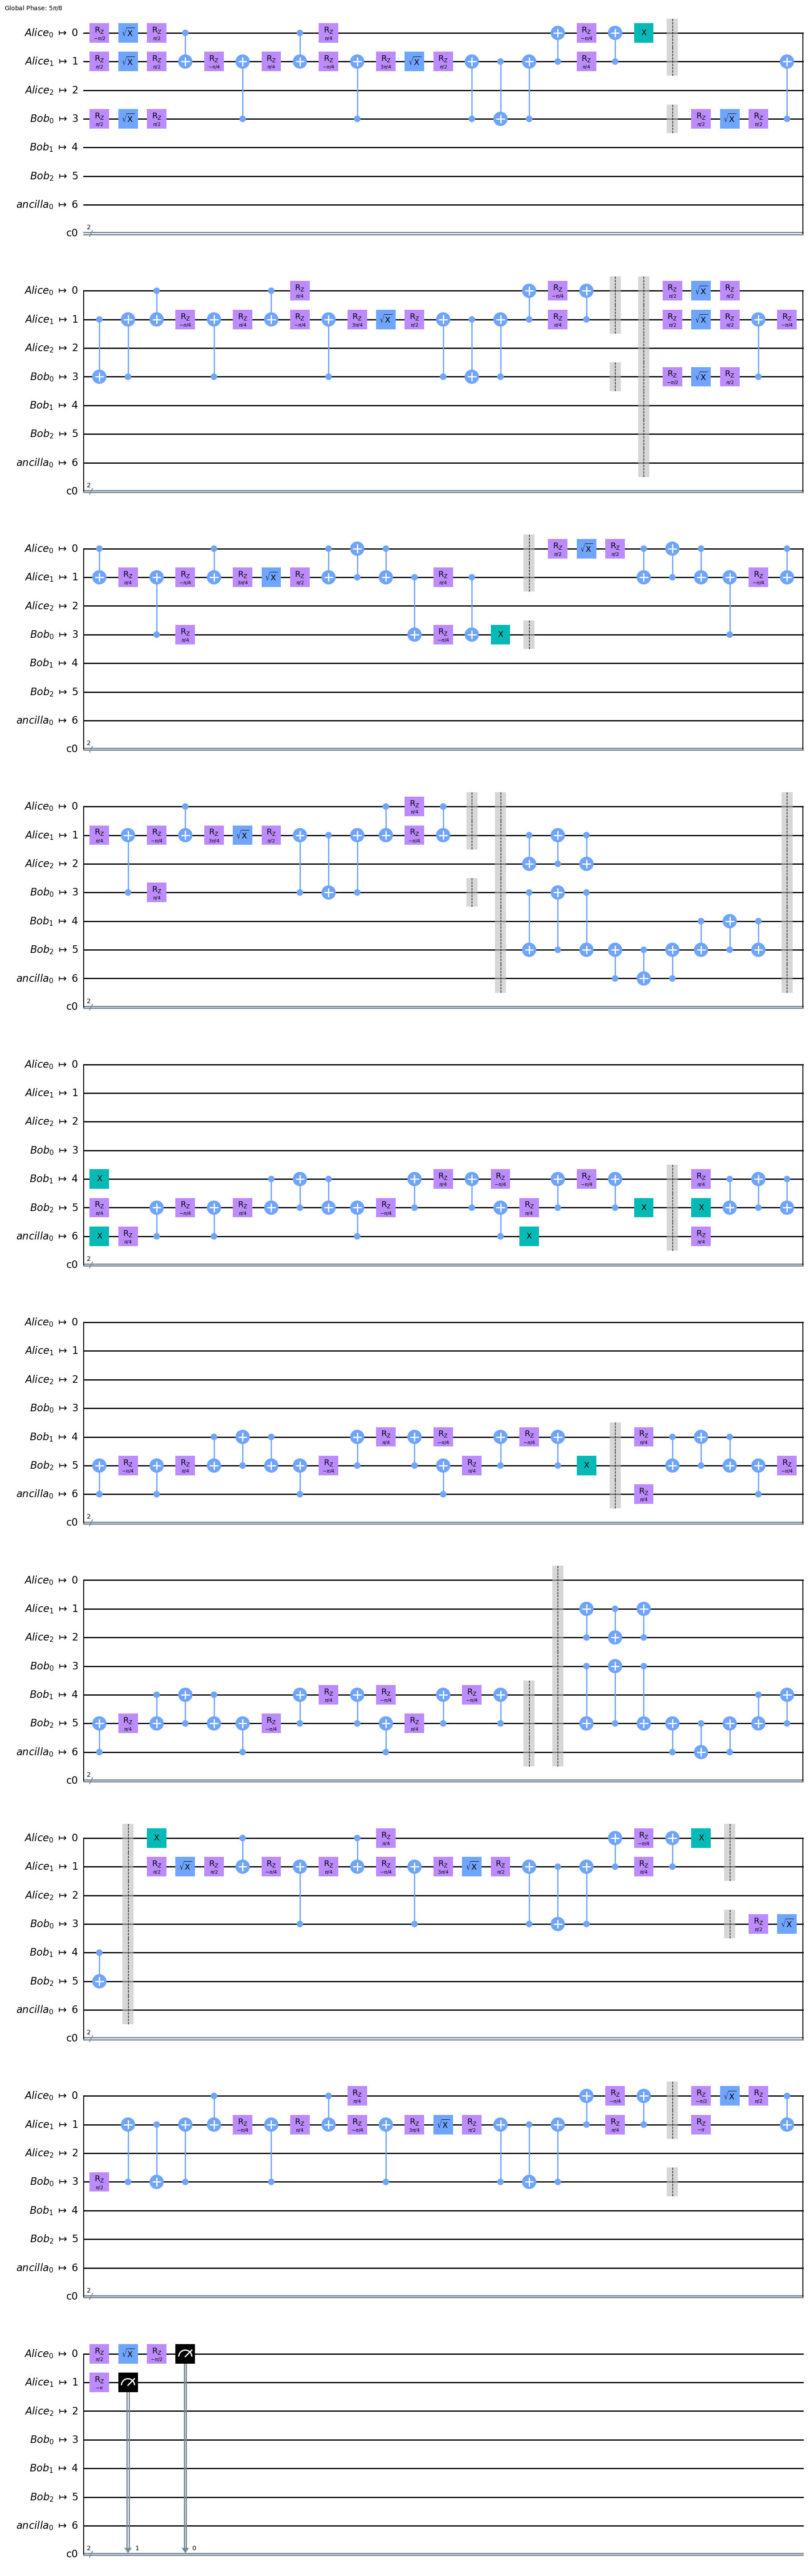

In [9]:
#######################################################################################################    
    
#      Grover's search algorithm
    
#######################################################################################################

Initialize_S(p1.qc, 0, nPosQubits)         # create the superposition state |s> for the working qubits of Alice 

nbSolutions = 1  # you need to enter the number of solutions

# number of iterations we have to run grover's algorithm
# iter = floor((ceil(sqrt(2**nPosQubits)) - 1)/nbSolutions) # if you know the number of solutions
iter = 1 # If we don't know the number of solutions
print("iter = ", iter)

# iterate approximately sqrt(N)
for i in range(iter):
    # oracle Alice
    CreateOracleAlice(p1.qc, numPos, calendar_a, nqubits)
    AddProtocolToQc(backend, transpiled_qc, p1) 
    transpiled_qc.barrier()  

    # swap with Bob
    SwapAll(transpiled_qc, backend, p1, p2)
    transpiled_qc.barrier()

    # oracle Bob
    CreateOracleBob(p2.qc, numPos, calendar_b, nqubits)
    AddProtocolToQc(backend, transpiled_qc, p2)
    transpiled_qc.barrier()
    
    # swap with Alice
    SwapAll(transpiled_qc, backend, p1, p2)
    transpiled_qc.barrier()

    # oracle Alice
    CreateOracleAlice(p1.qc, numPos, calendar_a, nqubits)
    AddProtocolToQc(backend, transpiled_qc, p1)

    #diffuser   
    AddDiffuser(transpiled_qc, backend, 0, nPosQubits)

#######################################################################################################    
    
#      Measurement
    
#######################################################################################################

# measurement
MesureQubits(transpiled_qc, nPosQubits)

# draw the global circuit
transpiled_qc.draw("mpl")

In [ ]:
#######################################################################################################    
    
#      Get simulator (simulator does not support layouts and coupling maps)
    
#######################################################################################################

# backend = Aer.get_backend('qasm_simulator') # uncomment if you want to run on a simulator

### Executer le code sur le backend
___

Le resultat recherche pour cet algorithme est la ou les positions des calendriers ou il y a une intersection.
Exemple: a = "0011" et b = "0110", le resultat est la position 2 (en commencant par 0). Le resultat affiche sera "10", le chiffre 2 en base 2.

In [ ]:
# job = backend.run(transpiled_qc)                  # run the job on the given backend
# results = list(job.result().get_counts().items()) # list of all results
# threshold = int(1024/3)                           # arbitrary threshold to isolate good results
# InverseResults(results, threshold)                # inverse the position answers (qubits in qiskit are inversed)

# plot_histogram(job.result().get_counts())         # uncomment to plot the result